In [ ]:
#!pip uninstall qiskit qiskit-nature -y
!pip install "qiskit==0.44.0" "qiskit-nature==0.6.2"
!pip install qiskit-nature-pyscf
!pip install numpy==1.25.2

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 60.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 1.6 MB/s eta 0:00:00
  Created wheel for qiskit: filename=qiskit-0.44.0-py3-none-any.whl size=7737 sha256=b96634862c8b829a746f022758ad3d3dd2cc85068c01997c8ee7ccf15963cc0c
  Stored in directory: /root/.cache/pip/wheels/7a/a4/36/917d8a18f80a0ba05a040ebc7625b49cdce2722aa96e2d8c92
Successfully built qiskit
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from pyscf import gto, dft
import numpy as np
import os

distancias = np.linspace(0.20, 3.00, 200)

for d in distancias:
    d_str = f"{d:.2f}".replace('.', '_')

    mol = gto.M(
        atom=f'H 0 0 0; H 0 0 {d}',
        basis='sto-3g',
        unit='Angstrom',
        verbose = 0,
    )

    mf = dft.RKS(mol)
    mf.xc = 'b3lyp'
    mf.kernel()

    n = mol.nao_nr()

    hcore = mf.get_hcore()
    eri_ao = mol.intor('int2e')
    eri_ao_flat = eri_ao.reshape(n**2, n**2)  # 2x2 = 4
    C = mf.mo_coeff

    # Construção da matriz de spin-orbitais para h_core
    h1_spin = np.zeros((2*n, 2*n))
    for i in range(n):
        for j in range(n):
            h1_spin[i, j] = hcore[i, j]           # alpha-alpha
            h1_spin[i+n, j+n] = hcore[i, j]       # beta-beta

    # Convertendo para notação do físico
    eri_phys = np.zeros((n, n, n, n))
    eri_chemist = eri_ao  # (ik|jl) padrão do PySCF
    for i in range(n):
        for j in range(n):
            for k in range(n):
                for l in range(n):
                    eri_phys[i, j, k, l] = eri_chemist[i, k, j, l]

    # Construção do tensor de 2 elétrons em spin-orbitais
    eri_spin = np.zeros((2*n, 2*n, 2*n, 2*n))
    for i in range(n):
        for j in range(n):
            for k in range(n):
                for l in range(n):
                    v = eri_phys[i, j, k, l]
                    eri_spin[i, j, k, l] = v
                    eri_spin[i+n, j+n, k+n, l+n] = v
                    eri_spin[i, j+n, k, l+n] = v
                    eri_spin[i+n, j, k+n, l] = v

    C_spin = np.zeros((2*n, 2*n))
    C_spin[:n, :n] = C       # bloco alpha
    C_spin[n:, n:] = C       # bloco beta

    eri_spin_flat = eri_spin.reshape(-1)
    np.savetxt(f"integral_1e_{d_str}.txt", h1_spin, fmt="%.10f")
    np.savetxt(f"integral_2e_{d_str}.txt", eri_spin_flat, fmt="%.10f")
    np.savetxt(f"coef_KS_{d_str}.txt", C_spin, fmt="%.10f")

In [22]:
import numpy as np


distancias = np.linspace(0.20, 3.00, 200)

for d in distancias:
    d_str = f"{d:.2f}".replace('.', '_')

    h_ao = np.loadtxt(f"integral_1e_{d_str}.txt")
    eri_ao_flat = np.loadtxt(f"integral_2e_{d_str}.txt")
    C = np.loadtxt(f"coef_KS_{d_str}.txt")

    n = C.shape[0] // 2

    eri_ao = eri_ao_flat.reshape(2*n,2*n,2*n,2*n)

    h_mo = C.T @ h_ao @ C
    np.savetxt(f"h_mo_{d_str}.txt", h_mo, fmt="%.10f")

    g_mo = np.zeros((2*n, 2*n, 2*n, 2*n))
    for i in range(2*n):
        for j in range(2*n):
            for k in range(2*n):
                for l in range(2*n):
                    for p in range(2*n):
                        for q in range(2*n):
                            for r in range(2*n):
                                for s in range(2*n):
                                    g_mo[i, j, k, l] += (
                                    C[p, i] * C[q, j] *
                                    eri_ao[p, q, r, s] *
                                    C[r, k] * C[s, l]
                                    )
    g_mo_flat = g_mo.reshape(-1)
    np.savetxt(f"g_mo_{d_str}.txt", g_mo_flat, fmt="%.10f")

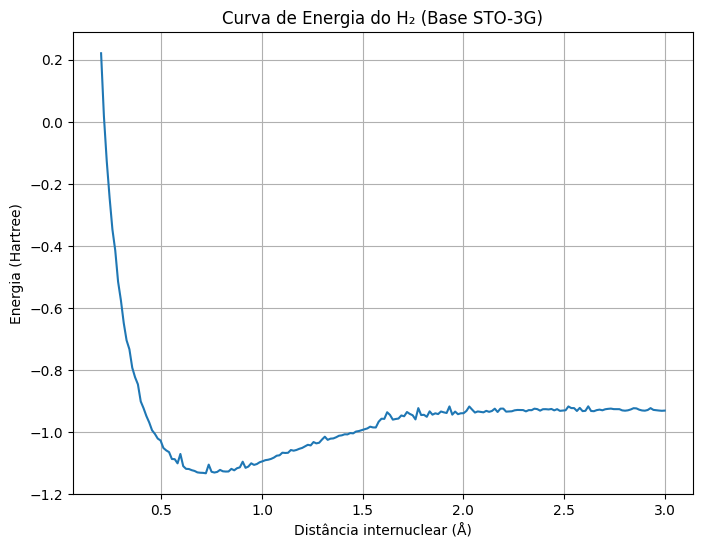

Menor energia: -1.132707 Hartree
Distância correspondente: 0.720603 Å


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit_nature.second_q.operators import FermionicOp
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_algorithms import VQE
from qiskit.circuit.library import EfficientSU2
from qiskit.primitives import Estimator
from qiskit_algorithms.optimizers import COBYLA
from qiskit.opflow import PauliSumOp
from qiskit.algorithms.optimizers import L_BFGS_B
from pyscf import gto
from qiskit_nature.second_q.circuit.library import UCCSD
from qiskit_nature.second_q.circuit.library import HartreeFock

distancias = np.linspace(0.20,3.00,200)
energias = []



for d in distancias:
    d_str = f"{d:.2f}".replace(".", "_")

    C = np.loadtxt(f"coef_KS_{d_str}.txt")

    n = C.shape[0] // 2

    mol = gto.M(atom=f"H 0 0 0; H 0 0 {d}",
                basis="sto-3g",
                unit="Angstrom"
                )
    energia_nuclear = mol.energy_nuc()


    h_ks = np.loadtxt(f"h_mo_{d_str}.txt")

    # Tensor g_ks fornecido
    g_ks = np.loadtxt(f"g_mo_{d_str}.txt")
    g_ks = g_ks.reshape(2*n, 2*n, 2*n, 2*n)

    n_orb = h_ks.shape[0]
    #Criação dos orbitais de spin
    n_spin_orb = n_orb

    # --- Termo de 1 elétron --- com a adição dos orbitais de spin
    h1_dict = {}
    for p in range(n_spin_orb):
        for q in range(n_spin_orb):
            val = h_ks[p, q]
            if abs(val) > 1e-12:
                h1_dict[f"+_{p} -_{q}"] = val

    h1 = FermionicOp(h1_dict, num_spin_orbitals=n_spin_orb)

    # --- Termo de 2 elétrons --- com a adição dos orbitais de spin
    h2_dict = {}
    for p in range(n_spin_orb):
        for q in range(n_spin_orb):
            for r in range(n_spin_orb):
                for s in range(n_spin_orb):
                    val = g_ks[p, q, r, s]
                    if abs(val) > 1e-12:
                        h2_dict[f"+_{p} +_{q} -_{s} -_{r}"] = 0.5 * val

    h2 = FermionicOp(h2_dict, num_spin_orbitals=n_spin_orb)

    fermionico_op = h1 + h2

    mapper = JordanWignerMapper()
    qubit_op = mapper.map(fermionico_op)


    ansatz = EfficientSU2(num_qubits=qubit_op.num_qubits, reps = 6, entanglement = 'full')

    vqe = VQE(
        Estimator(),
        ansatz=ansatz,
        optimizer=COBYLA(maxiter = 400),
        initial_point=[0.0] * ansatz.num_parameters
    )

    vqe_resultado = vqe.compute_minimum_eigenvalue(qubit_op)
    energia_eletronica = vqe_resultado.eigenvalue.real
    total_energy = energia_eletronica + energia_nuclear
    energias.append(total_energy)

plt.figure(figsize=(8, 6))
plt.plot(distancias, energias)
plt.title("Curva de Energia do H₂ (Base STO-3G)")
plt.xlabel("Distância internuclear (Å)")
plt.ylabel("Energia (Hartree)")
plt.grid(True)
plt.show()

# Encontrar o índice da menor energia
idx_min = np.argmin(energias)

# A menor energia e a distância correspondente
energia_minima = energias[idx_min]
distancia_minima = distancias[idx_min]

print(f"Menor energia: {energia_minima:.6f} Hartree")
print(f"Distância correspondente: {distancia_minima:.6f} Å")